# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

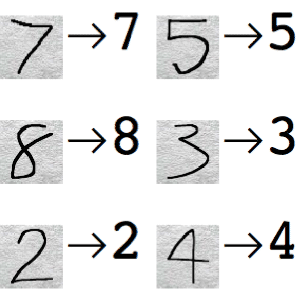

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-03 15:27:22.295500: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 15:27:22.512288: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 15:27:23.154992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 15:27:25.962435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

In [ ]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [ ]:
run_test_harness2()

## Make Prediction

IMAGE MODIFICATION
1. Hàm load_image sau khi load ảnh vào, với giả định nền là màu trắng và chữ số viết bằng màu khác trắng
sẽ tiến hàn gọi hàm invert_if_white.

2. Hàm invert_if_white thực hiện các bước sau:
    + Tính toán giá trị trung bình của các pixel ảnh (giá trị pixel <=> màu).
    + Nếu giá trị này > 128 (xám trung), tức màu sáng chiếm nhiều hơn màu tối, thực hiện âm bản ảnh (nghịch đảo màu), sau đó đến bước tiếp theo.
    + Biến mọi pixel ảnh có giá trị > 128 (sáng hơn màu xám) thành màu trắng, và ngược lại thành màu đen.
    + Gọi hàm crop_img để cắt ảnh về kích thước 28x28 pixel.

3. Hàm crop_img thực hiện các bước sau:
    + Gọi hàm np.array từ thư viện numpy, biến ảnh thành một mảng chứa thông tin về cường độ của màu cơ bản ở mỗi pixel ảnh (ví dụ đối với ảnh grayscale thì sẽ là trắng - đen, còn ảnh màu thì là đỏ-lục-lam).
    + Tìm các pixel sáng hơn giá trị 128 (màu xám), tính toán vị trị trung tâm của vùng sáng này (vì ảnh đã trải qua việc biến nền thành đen và chữ số thành trắng) để chuẩn bị tiến hành cắt ảnh.
    + Tính toán khoảng cách từ tâm đến mỗi pixel trắng và tìm khoảng cách tối đa từ tâm 
đến rìa vùng trắng.
    + Tiến hành cắt ảnh và thu nhỏ ảnh về kích thước 28x28 pixel.

In [2]:
import os, glob
from PIL import Image, ImageOps
import numpy as np

def crop_img(img, x):
    # from center of the most white area, crop image such that the black area is x% of the original image
    # img: PIL image
    # x: percentage of black area in the original image
    # return: PIL image

    # Convert the image to a numpy array
    img = np.array(img)
    # find the center of the most white area

    white = np.where(img > 128)
    center = (int(np.mean(white[0])), int(np.mean(white[1])))
    
    # Calculate the distance from the center to the edge of the image
    distances = np.sqrt((white[0] - center[0])**2 + (white[1] - center[1])**2)
    max_distance = np.max(distances)

    # Calculate the padding
    for i in range(int(max_distance), 0, -1):
        if np.sum(distances < i) / len(distances) < 0.98:
            break
    pad = i


    # Crop the image
    img = img[center[0] - pad:center[0] + pad, center[1] - pad:center[1] + pad]

    # Convert the image to a PIL image
    img = Image.fromarray(img)

    # Resize the image to 28x28
    img = img.resize((28, 28))

    return img

def invert_if_white(img):

    # Calculate the average pixel value
    avg_pixel_value = np.mean(np.array(img))

    # If the image is mainly white
    if avg_pixel_value > 128:
        # Invert the colors
        img = ImageOps.invert(img)
    img = img.point(lambda p: p >= 128 and 255)
    img = crop_img(img, 0.1)
    return img


def load_image(filename):
    # load the image
    img = load_img(filename, color_mode='grayscale')
    img = invert_if_white(img)
    # convert to array
    img = img_to_array(img)

    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0

    return img

In [ ]:
#Check image after load <- comment the convert to array, reshape, prepare pixel data in load_image function 
#Uncomment the code below
""" image = load_image(r'/home/duy/Pictures/gra/grayscale/9(2).jpg')
plt.imshow(image, cmap=plt.get_cmap('gray')) """

1. Sửa đổi nhằm có thể nhập vào nhiều hình ảnh một lần.
2. Lưu ảnh đoán đúng vào correct, sai vào wrong.
3. Với những ảnh đoán sai, xuất ra: 
    + kết quả đã dự đoán.
    + đường dẫn của ảnh dự đoán sai. 
    + ảnh ban đầu.
    + ảnh đã qua định dạng để thực hiện dự đoán. 

In [4]:
# load an image and predict the class
def run_example():
  wrong = []
  correct = []
  folder = '/home/duy/CS114.O21/LAB01/data/22520327'
  #load the model
  model = load_model('/home/duy/CS114.O21/LAB01/final_model.h5')
  # load the image
  for i in range (0,10):
    files = glob.glob(f'{folder}/**/{i}*.jpg', recursive=True)
    for f in files:
      img = load_image(f)
      # predict the class
      predict_value = model.predict(img)

      digit = argmax(predict_value)
      if digit == i:
        correct.append(f)
      else:
        wrong.append(f)
        #print out preditct value
        print(f'Predict: {digit}')
        print(f)  #Print out the path of the image
        #Print the original and modified image to compare
        print('Original:')  
        original_img = Image.open(f)
        plt.imshow(original_img, cmap=plt.get_cmap('gray'))
        plt.show()
        print('Modified:')
        plt.imshow(img.reshape(28,28), cmap=plt.get_cmap('gray'))
        plt.show()
  print(f"Correct: {len(correct)}")
  print(f"Wrong: {len(wrong)}")




Kết quả chạy thử với 60 ảnh: tỉ lệ chính xác đạt khoảng 86%, với điều kiện ảnh đa phần đều rõ nét, độ tương phản ánh sáng rõ ràng.

Kết luận cá nhân: 
+ Tính ứng dụng của mô hình là không cao, kích thước ảnh để có thể tiến hành dự đoán quá nhỏ, khó phù hợp với thực tiễn. 
+ Khi tiến hành chỉnh sửa ảnh tất yếu sẽ làm giảm chất lượng ảnh, dẫn đến dự đoán sai. Cách cải tiến do em thực hiện còn một số hạn chế như phụ thuộc vào điều kiện ánh sáng khi chụp; ảnh phải chụp ở cự li rất gần (em chụp ở lens x5 lần) và đảm bảo rõ nét, chỉ lấy nền trắng và chữ số. 
+ Nếu nền ảnh có màu khác ngoài màu 1 màu chủ đạo thì có thể dẫn dến load_img() sẽ cho ra ảnh đen kịch, kết quả dự đoán sẽ sai.

/home/duy/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predict: 4
/home/duy/CS114.O21/LAB01/data/22520327/1/1(2).jpg
Original:


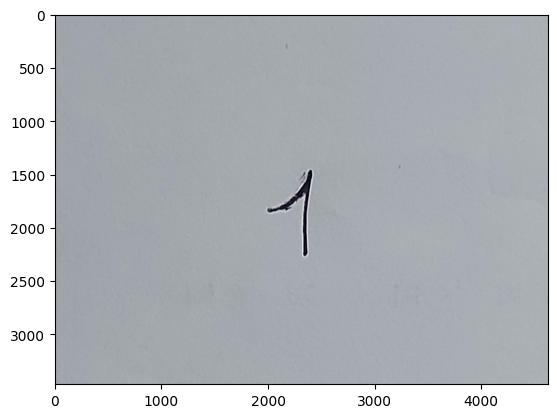

Modified:


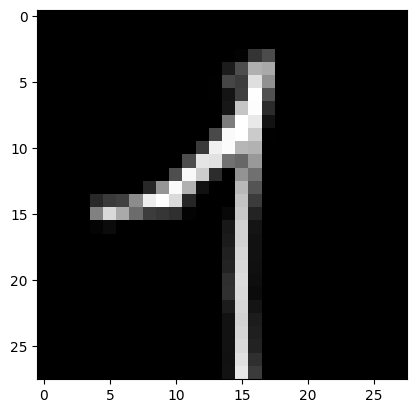

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predict: 4
/home/duy/CS114.O21/LAB01/data/22520327/1/1(1).jpg
Original:


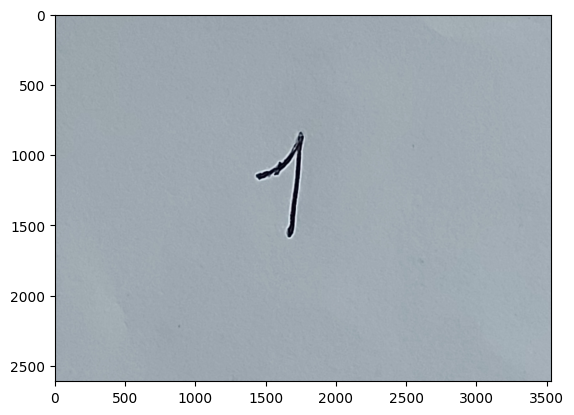

Modified:


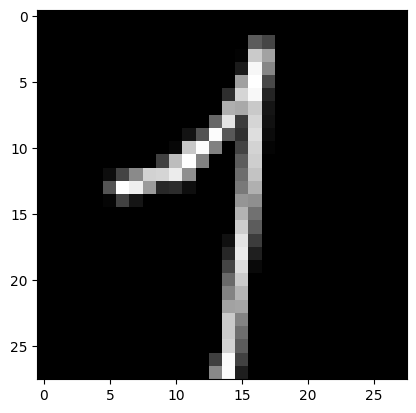

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predict: 4
/home/duy/CS114.O21/LAB01/data/22520327/1/1(3).jpg
Original:


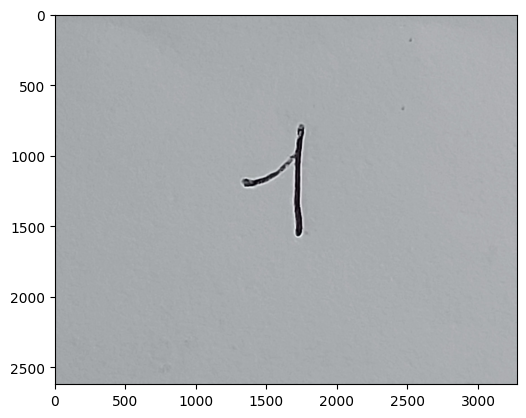

Modified:


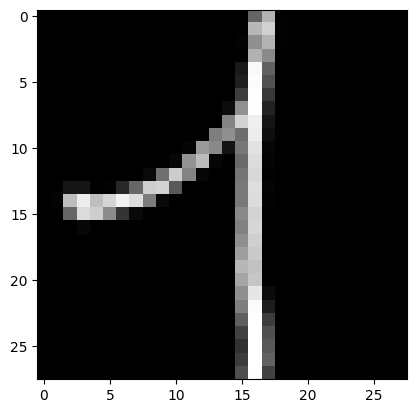

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

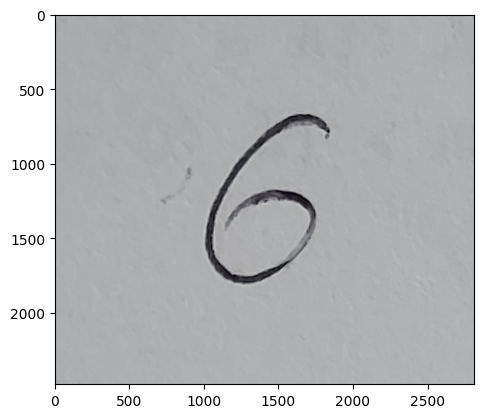

Modified:


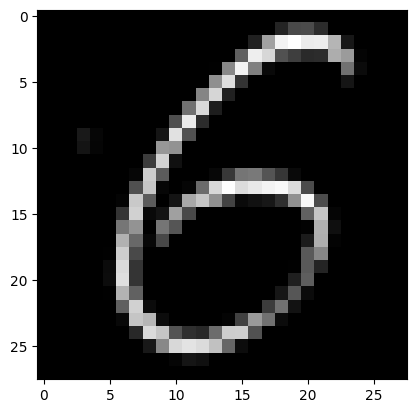

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predict: 5
/home/duy/CS114.O21/LAB01/data/22520327/6/6(2).jpg
Original:


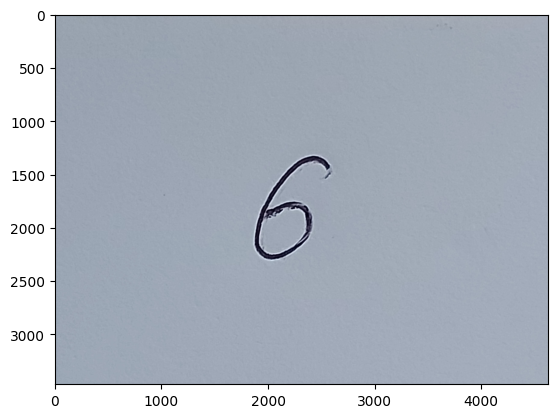

Modified:


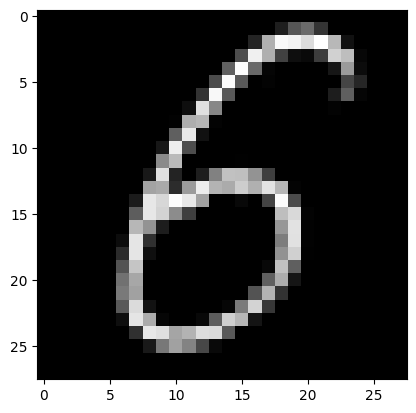

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predict: 5
/home/duy/CS114.O21/LAB01/data/22520327/6/6(3).jpg
Original:


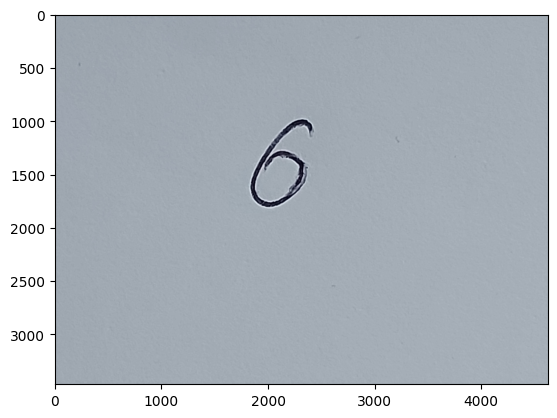

Modified:


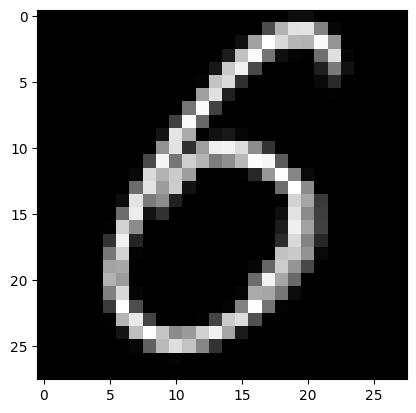

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predict: 5
/home/duy/CS114.O21/LAB01/data/22520327/6/6(6).jpg
Original:


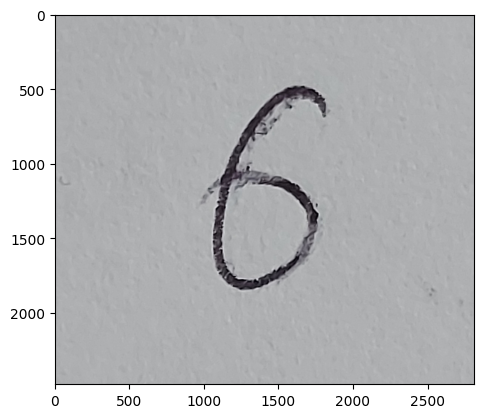

Modified:


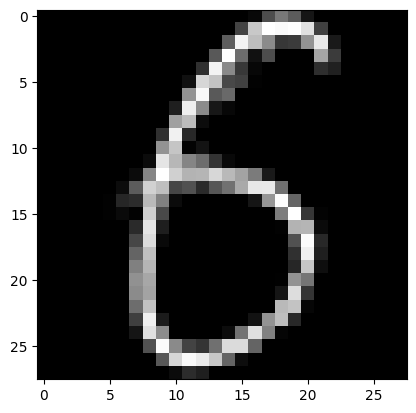

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predict: 3
/home/duy/CS114.O21/LAB01/data/22520327/7/7(2).jpg
Original:


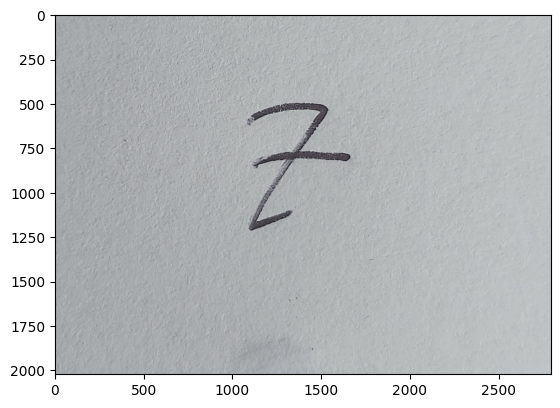

Modified:


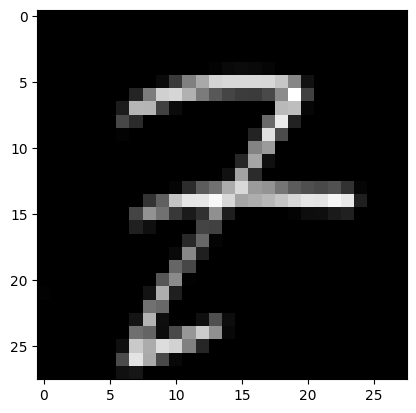

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Correct: 52
Wrong: 8


In [5]:
#Run example
run_example()